# AIS trajectory synthetic generator

## Description
* Entire data in the dataframe are from relative perspective, i.e., wrt ego ASV

In [26]:
import numpy as np
import pandas as pd
import math
import copy
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)
from mpl_toolkits.basemap import Basemap
import geopandas as gpd
from scipy.spatial import ConvexHull
from timeit import default_timer as timer
from datetime import datetime
from datetime import timedelta

import random
from aux_code.learning_preprocess import convert_rad_angle_from_robotic_to_NED

## TODOs
* different seq length

In [27]:
# Constants
situation = ['crossing', 'overtaking', 'headon']
# situation = ['crossing', 'headon']
# situation = ['headon']
crossing_situation = ['crossing_from_l', 'crossing_from_r']

CROSS_FROM_R = [[0, 200], [-200, 200]] # [x_min, x_max], [y_min, y_max]
CROSS_FROM_R_END = [[-200, 0], [-200, 200]]
CROSS_FROM_L = [[-200, 0], [-200, 200]]
CROSS_FROM_L_END = [[0, 200], [-200, 200]] 
OVERTAKING = [[-100, 100], [0, 50]]
OVERTAKING_END = [[-100, 100], [100, 200]]
HEADON = [[-100, 100], [0, 200]]
HEADON_END = [[-100, 100], [-200, -100]]

TOTAL_RUN_TIME = 300 # sec
TIME_STEP_SIZE = 1 # sec
MONITORING_DIST = 100 # meter


MY_START_PSN = [0, -100]
MY_END_PSN = [0, 100]
MY_ROBOT_SPD = 2.5
MY_HDG = math.pi / 2
COLL_DIST_THRESH = 15

NOISE_ADD = True
ONLY_FOWARD_COME = True

encounter_dist = 80 # m
clearing_cond_dist = 20 # m
clearing_cond_angle = 112.5

In [28]:
entire_situation = dict()

In [29]:
def fix_heading(i_start_psn, i_end_psn):
    """
    function to fix start heading by connecting start and end position
    """
    start_x = i_start_psn[0]
    start_y = i_start_psn[1]
    end_x = i_end_psn[0]
    end_y = i_end_psn[1]

    delta_x = end_x - start_x
    delta_y = end_y - start_y
    hdg = math.atan2(delta_y, delta_x)

    return hdg

def get_distance_two_coor(start, end):
    """
    two coordinates (1 x 2) array distance
    """
    return math.sqrt((end[0] - start[0])**2 + (end[1] - start[1])**2)

def get_linspace(start, stop, step=1.):
  """
    Like np.linspace but uses step instead of num
    This is inclusive to stop, so if start=1, stop=3, step=0.5
    Output is: array([1., 1.5, 2., 2.5, 3.])
  """
  return np.linspace(start, stop, int((stop - start) / step + 1))

def get_transmat_g_wrt_r(my_hdg):
    """
    already rel_x, rel_y calculation based on the global frame is assuemd
    """

    try:
        # g_R_r = np.array([[np.cos(my_hdg), -np.sin(my_hdg)],
        #                     [np.sin(my_hdg), np.cos(my_hdg)]])
        # r_R_g = np.linalg.inv(g_R_r)

        g_R_r = np.array([[np.cos(my_hdg), -np.sin(my_hdg), 0, 0],
                            [np.sin(my_hdg), np.cos(my_hdg), 0, 0], 
                            [0, 0, 1, 0],
                            [0, 0, 0, 1]])

        r_R_g = np.linalg.inv(g_R_r)

        return r_R_g

    except Exception as e:
        print(e)
        pass

def get_distance_two_array(X1, Y1, X2, Y2):
    """
    arrays coodrinate (X, Y, X', Y;) distance
    """
    return np.sqrt(np.power(X2-X1, 2) + np.power(Y2-Y1, 2))

def check_vector_angle(vec1, vec2):
    # type: (np.array, np.array) -> float
    """
    function to return vector angle by vec1 as a base
    https://math.stackexchange.com/questions/878785/how-to-find-an-angle-in-range0-360-between-2-vectors/879474

    Arguments: 
        - vec1, vec2 format np.array([x,y]) 1x2, i.e., dim (2,)

    Returns: 
        - angle (radian): [-math.pi, math.pi]
    """

    # dot product and determinant    
    dot_product = vec1[0] * vec2[0] + vec1[1] * vec2[1]
    determinant = vec1[0] * vec2[1] - vec1[1] * vec2[0]
    angle = math.atan2(determinant, dot_product)

    return angle

In [30]:
def random_obs_generator(robot_idx):
    robot_name = 'robot_{}'.format(robot_idx)
    random.seed()
    i_situation = random.choice(situation)
    start_x, start_y, end_x, end_y = None, None, None, None


    if i_situation == 'crossing':
        i_cross_situation = random.choice(crossing_situation)
        if i_cross_situation == 'crossing_from_l':
            random.seed()
            start_x = random.randint(CROSS_FROM_L[0][0], CROSS_FROM_L[0][1])
            random.seed()
            start_y = random.randint(CROSS_FROM_L[1][0], CROSS_FROM_L[1][1])
            random.seed()
            end_x = random.randint(CROSS_FROM_L_END[0][0], CROSS_FROM_L_END[0][1])
            random.seed()
            end_y = random.randint(CROSS_FROM_L_END[1][0], CROSS_FROM_L_END[1][1])
        elif i_cross_situation == 'crossing_from_r': # start from right
            random.seed()
            start_x = random.randint(CROSS_FROM_R[0][0], CROSS_FROM_R[0][1])
            random.seed()
            start_y = random.randint(CROSS_FROM_R[1][0], CROSS_FROM_R[1][1])

            # 2) end psn
            random.seed()
            end_x = random.randint(CROSS_FROM_R_END[0][0], CROSS_FROM_R_END[0][1])
            random.seed()
            end_y = random.randint(CROSS_FROM_R_END[1][0], CROSS_FROM_R_END[1][1])

    elif i_situation == 'overtaking':
        random.seed()
        start_x = random.randint(OVERTAKING[0][0], OVERTAKING[0][1])
        random.seed()
        start_y = random.randint(OVERTAKING[1][0], OVERTAKING[1][1])
        
        # TODO start position checker
        # res_start_psn = check_start_position([start_x, start_y], entire_situation)
        # if not res_start_psn:
        #     continue

        # 2) end psn
        random.seed()
        end_x = random.randint(-20, 20) + start_x
        random.seed()
        end_y = random.randint(OVERTAKING_END[1][0], OVERTAKING_END[1][1])

    elif i_situation == 'headon':

        random.seed()
        start_x = random.randint(HEADON[0][0], HEADON[0][1])
        random.seed()
        start_y = random.randint(HEADON[1][0], HEADON[1][1])

        # 2) end psn
        random.seed()
        end_x = random.randint(-20, 20) + start_x
        random.seed()
        end_y = random.randint(HEADON_END[1][0], HEADON_END[1][1])

        # start_x = -30
        # start_y = 100
        # end_x = -30
        # end_y = -100


        # start_x = -100
        # start_y = 100
        # end_x = 50
        # end_y = -100


        # start_x = 100
        # start_y = 100
        # end_x = -100
        # end_y = -10


    # 3) heading generation
    # hdg = round(math.degrees(fix_heading([start_x,start_y], [end_x,end_y]))) # robotic frame
    other_hdg = fix_heading([start_x,start_y], [end_x,end_y]) # robotic frame, radian
    other_hdg_ned = convert_rad_angle_from_robotic_to_NED(other_hdg) # NED frame, radian
    # hdg= round(math.degrees(hdg))

    # 4) speed
    other_spd = random.randint(1, 5)

    print("situation: {}".format(i_situation))
    if i_situation == "crossing":
        print("cross: {}".format(i_cross_situation))
    print("coordinates {}".format((start_x, start_y, end_x, end_y )))
    print("hdg {} hdg_ned {}".format(round(math.degrees(other_hdg)), round(math.degrees(other_hdg_ned))))
    print("spd {}".format(other_spd))


    return start_x, start_y, end_x, end_y, other_spd, other_hdg, other_hdg_ned, i_situation



In [31]:
# time_array
time_array = get_linspace(0, TOTAL_RUN_TIME, TIME_STEP_SIZE)

### data frame for obs motion

In [32]:
def get_obs_motion_global(start_x, start_y, end_x, end_y, spd, hdg, hdg_ned, i_situation):
    """ my motion """
    my_start_psn = MY_START_PSN
    my_end_psn = MY_END_PSN
    my_robot_spd = MY_ROBOT_SPD
    my_hdg = fix_heading(my_start_psn, my_end_psn)

    my_time_max = (get_distance_two_coor(my_start_psn, my_end_psn) / my_robot_spd) if my_robot_spd != 0 else TOTAL_RUN_TIME
    # my_time_max

    # x_trajectory of obstacle
    my_expected_x_global = np.where(time_array <= my_time_max, 
                    my_start_psn[0] + time_array * my_robot_spd * math.cos(my_hdg), 
                    my_end_psn[0])
    # y_trajectory of obstacle
    my_expected_y_global = np.where(time_array <= my_time_max, 
                    my_start_psn[1] + time_array * my_robot_spd * math.sin(my_hdg), 
                    my_end_psn[1])

    my_vec_global = np.array([my_robot_spd * math.cos(my_hdg), my_robot_spd * math.sin(my_hdg)])


    """ other motion """
    i_start_psn = [start_x, start_y]
    i_end_psn = [end_x, end_y]
    i_robot_spd = spd
    i_robot_hdg = hdg

    i_time_max = (get_distance_two_coor(i_start_psn, i_end_psn) / i_robot_spd) if i_robot_spd != 0 else TOTAL_RUN_TIME
    # i_time_max

    # x_trajectory of obstacle
    i_expected_x_global = np.where(time_array <= i_time_max, 
                    i_start_psn[0] + time_array * i_robot_spd * math.cos(i_robot_hdg), 
                    i_end_psn[0])
    # y_trajectory of obstacle
    i_expected_y_global = np.where(time_array <= i_time_max, 
                    i_start_psn[1] + time_array * i_robot_spd * math.sin(i_robot_hdg), 
                    i_end_psn[1])

    i_vec_global = np.array([i_robot_spd * math.cos(i_robot_hdg), i_robot_spd * math.sin(i_robot_hdg)])

    if NOISE_ADD:
        i_x_noise = np.random.normal(0, 0.5, np.shape(i_expected_x_global))
        i_y_noise = np.random.normal(0, 0.5, np.shape(i_expected_y_global))

        i_expected_x_global += i_x_noise
        i_expected_y_global += i_y_noise

    """ collision check """
    # distance array as vectorization
    dist_array = get_distance_two_array(my_expected_x_global, my_expected_y_global, i_expected_x_global, i_expected_y_global)

    dist_bool_array = (dist_array <= COLL_DIST_THRESH)
    dist_bool = np.any(dist_bool_array)

    if dist_bool:
        print("distance not matching")
        return


    """ build up data for DataFrame"""
    i_expected_x_rel_global = i_expected_x_global - my_expected_x_global
    i_expected_y_rel_global = i_expected_y_global - my_expected_y_global

    # rel distance of obstacle
    rel_dist = np.sqrt(i_expected_x_rel_global**2 + i_expected_y_rel_global**2)

    # rel bearing of obstacle
    r_R_g= get_transmat_g_wrt_r(my_hdg)
    i_expected_xy_rel_global = np.vstack([i_expected_x_rel_global, i_expected_y_rel_global])
    i_expected_xy_rel_global = np.vstack([i_expected_xy_rel_global, np.zeros(np.shape(i_expected_x_rel_global))])
    i_expected_xy_rel_global = np.vstack([i_expected_xy_rel_global, np.ones(np.shape(i_expected_x_rel_global))])

    i_expected_xy_rel_wrt_my = np.matmul(r_R_g, i_expected_xy_rel_global)

    rel_bearing = np.arctan2(i_expected_xy_rel_wrt_my[1,:], i_expected_xy_rel_wrt_my[0,:]) # y, x
    comp_bearing = np.arctan2(i_expected_y_rel_global, i_expected_x_rel_global)


    """ actual build of DataFrame """
    df_rel_obj = pd.DataFrame()
    df_rel_obj['x'] = i_expected_xy_rel_wrt_my[0,:]
    df_rel_obj['y'] = i_expected_xy_rel_wrt_my[1,:]
    df_rel_obj['v_x'] = df_rel_obj['x'].diff() / TIME_STEP_SIZE # relative vel x
    df_rel_obj['v_y'] = df_rel_obj['y'].diff() / TIME_STEP_SIZE # relative vel y
    df_rel_obj['global_x'] = i_expected_x_rel_global
    df_rel_obj['global_y'] = i_expected_y_rel_global
    df_rel_obj['rel_dist'] = rel_dist
    df_rel_obj['rel_bearing'] = rel_bearing
    df_rel_obj['rel_bearing_diff'] = df_rel_obj['rel_bearing'].diff()
    df_rel_obj[df_rel_obj['rel_bearing_diff'] > np.pi] -= np.pi * 2
    df_rel_obj[df_rel_obj['rel_bearing_diff'] < -np.pi] += np.pi * 2
    df_rel_obj['comp_bearing'] = comp_bearing
    df_rel_obj['comp_bearing_diff'] = df_rel_obj['comp_bearing'].diff()
    df_rel_obj[df_rel_obj['comp_bearing_diff'] > np.pi] -= np.pi * 2
    df_rel_obj[df_rel_obj['comp_bearing_diff'] < -np.pi] += np.pi * 2
    df_rel_obj['Heading'] = round(np.degrees(hdg_ned)) 
    df_rel_obj['situation'] = i_situation
    df_rel_obj['sin_rel_bearing'] = np.sin(rel_bearing)
    df_rel_obj['cos_rel_bearing'] = np.cos(rel_bearing)
    df_rel_obj['sin_comp_bearing'] = np.sin(comp_bearing)
    df_rel_obj['cos_comp_bearing'] = np.cos(comp_bearing)
    return df_rel_obj



In [33]:
    # TODO what I missed
    # 1. this did not cropped well to the end
    # 2. start_idx 0 stopped
    # 3. df_rel_obj_crop_pass more smaller


In [34]:
def get_final_dataframe(df_rel_obj, other_idx, other_start_x, other_start_y, other_end_x, other_end_y, other_spd, other_hdg):

    """ my motion """
    my_start_psn = MY_START_PSN
    my_end_psn = MY_END_PSN
    my_robot_spd = MY_ROBOT_SPD
    my_hdg = fix_heading(my_start_psn, my_end_psn)

    my_vec_global = np.array([my_robot_spd * math.cos(my_hdg), my_robot_spd * math.sin(my_hdg)])


    """ other motion """
    i_start_psn = [other_start_x, other_start_y]
    i_end_psn = [other_end_x, other_end_y]
    i_robot_spd = other_spd
    i_robot_hdg = other_hdg


    i_vec_global = np.array([i_robot_spd * math.cos(i_robot_hdg), i_robot_spd * math.sin(i_robot_hdg)])

    encounter_cond = (df_rel_obj['rel_dist'] <= encounter_dist).any()
    """ encounter detail condition crop """
    # meaning encounter as below a certain distance  
    if encounter_cond: 
        ########################################################## 
        # 0) pre-processing to find whether actually passing happened
        ##########################################################

        crop_start_idx = df_rel_obj.index[df_rel_obj['rel_dist'] <= MONITORING_DIST][0]
        df_rel_obj_crop = (df_rel_obj.iloc[crop_start_idx:].copy()).reset_index(drop=True)

        # print("cropped \n", df_rel_obj_crop)

        enter_idx = 0 
        clear_idx = 0
        entered_flag = False

        for k in range(len(df_rel_obj_crop)):
            rel_dist_current = df_rel_obj_crop['rel_dist'].iloc[k]
            rel_bearing_current = df_rel_obj_crop['rel_bearing'].iloc[k]

            
            if not entered_flag and rel_dist_current <= encounter_dist:
                """ entering condition """
                entered_flag = True

            elif entered_flag:
                """ clearing condition """

                # LOS is based on global, not relative wrt my ASV
                global_LOS_vec = np.array([df_rel_obj_crop['global_x'].iloc[k], df_rel_obj_crop['global_y'].iloc[k]])

                global_rel_vec_wrt_other = my_vec_global - i_vec_global
                dot_product = np.dot(global_rel_vec_wrt_other, global_LOS_vec)
                # print("rel dist {} rel bear {} dot {}".format(rel_dist_current, rel_bearing_current, dot_product))
                
                intersect_angle = check_vector_angle(global_rel_vec_wrt_other, global_LOS_vec) 

                if dot_product < 0 and \
                rel_dist_current >= clearing_cond_dist and \
                abs(intersect_angle) >= np.radians(clearing_cond_angle):
                    clear_idx = k
                    break
            
        ########################################################## 
        # 1) valid encounter find: approaching from the front side
        ##########################################################

        # print("clear_idx {}".format(clear_idx))

        if clear_idx != 0:
            # 1) pos_x extraction to extract coming from front
            df_rel_obj_crop_pass = df_rel_obj_crop.iloc[:clear_idx].copy()

            ###################################
            df_rel_obj_crop_use = df_rel_obj_crop # 1) from enter to end
            # df_rel_obj_crop_use = df_rel_obj_crop_pass # 2) from enter to clear
            # df_rel_obj_crop_use = df_rel_obj # 3) all trajectory
            

            df_rel_obj_crop_use = df_rel_obj_crop_use.reset_index(drop=True)
            # print("df_rel_obj_crop_use {}".format(df_rel_obj_crop_use))
            ###################################

            init_pos_x = df_rel_obj_crop_pass['x'].iloc[0] # init position as enter
            last_pos_x = df_rel_obj_crop['x'].iloc[-1] # final position till the end
            init_pos_y = df_rel_obj_crop_pass['y'].iloc[0] # init position as enter
            last_pos_y = df_rel_obj_crop['y'].iloc[-1] # final position till the end

            ###################################
            # coming from the aft
            ###################################
            if init_pos_x <= 0: 
                if ONLY_FOWARD_COME:
                    return # only from front 
                else:
                    pass
            
                # 1) overtaken
                if last_pos_x >=0: # last position 1,4 quadrant
                    df_rel_obj_crop_use['valid'] = True
                    df_rel_obj_crop_use['obj_index'] = other_idx

                    print("=================================================here1")
                
                # 2) crossing but passing behind
                else: # last position also 2,3 quadrant
                    if init_pos_y <= 0: # 3rd quadrant
                        # 2-1) check it goes above x
                        if last_pos_y >= 0: # passing and clear condition already checked by dot and rel-bearing above
                            df_rel_obj_crop_use['valid'] = True
                            df_rel_obj_crop_use['obj_index'] = other_idx
                            print("=================================================here2")
                        # 2-2) check it pass behind certain distance (last output)
                        elif np.sqrt(np.power(last_pos_x,2) + np.power(last_pos_y,2)) >= MONITORING_DIST:
                            df_rel_obj_crop_use['valid'] = True
                            df_rel_obj_crop_use['obj_index'] = other_idx
                            print("=================================================here3")
                        else:
                            print("=================================================except1")
                            return
                    else: # 2nd quadrant
                        # 2-1) check it goes below x
                        if last_pos_y <= 0: # passing and clear condition already checked by dot and rel-bearing above
                            df_rel_obj_crop_use['valid'] = True
                            df_rel_obj_crop_use['obj_index'] = other_idx
                            print("=================================================here4")
                        elif np.sqrt(np.power(last_pos_x,2) + np.power(last_pos_y,2)) >= MONITORING_DIST:
                            df_rel_obj_crop_use['valid'] = True
                            df_rel_obj_crop_use['obj_index'] = other_idx
                            print("=================================================here5")
                        else:
                            print("=================================================except2")
                            return                          

            ###################################
            # coming from the front
            ###################################
            else: # init_pose >= 0
                # 3-1) either crossing from forward (can be bow crossing or not)
                # 3-2) head-on
                if last_pos_x <= 0: # ended up passing 
                    # TODO this return and TEST sanity check
                    df_rel_obj_crop_use['valid'] = True
                    df_rel_obj_crop_use['obj_index'] = other_idx
                    print("=================================================here6")
                    
                # 4) didn't pass and cleared my beam
                else: 
                    # it never pass my abeam --> should be skipped
                    print("=================================================here7")
                    return
                    
            print("MMSI {} found valid ....... ".format(other_idx))


            ########################################################## 
            # 2) angle difference, r, and winding number
            ##########################################################
            if bool(df_rel_obj_crop_use['valid'].iloc[0]):
                # passing homotopy
                winding_number = df_rel_obj_crop_use['comp_bearing_diff'].sum()
                # winding_number = df_rel_obj_crop_use['rel_bearing_diff'].sum()
                print("winding number {}".format(winding_number))
                if winding_number > 0:
                    # print("passing on my L side")
                    df_rel_obj_crop_use['label'] = 'L' # entire cell mapping
                
                
                elif winding_number < 0:
                    # print("passing on my R side")
                    df_rel_obj_crop_use['label'] = 'R' # entire cell mapping

                return df_rel_obj_crop_use.reset_index(drop=True)

In [35]:
path_save = 'synthetic_data/noise' if NOISE_ADD else 'synthetic_data/no_noise'

In [36]:
def wrapping_function_obtain_data(total_desire_num, final_drawing=False):
    other_idx = 0
    file_name = "synthetic"
    label_l_total = 0
    label_r_total = 0
    desired_half = total_desire_num / 2
    print("starting generation synthetic .............")

    while True:
        other_start_x, other_start_y, other_end_x, other_end_y, other_spd, other_hdg, other_hdg_ned, i_situation = random_obs_generator(other_idx)
        df_rel_obj = get_obs_motion_global(other_start_x, other_start_y, other_end_x, other_end_y, other_spd, other_hdg, other_hdg_ned, i_situation)
        if df_rel_obj is None: # edge condition
            continue
        else:
            df_rel_obj_crop = get_final_dataframe(df_rel_obj, other_idx, other_start_x, other_start_y, other_end_x, other_end_y, other_spd, other_hdg)

            if df_rel_obj_crop is not None:
                label = df_rel_obj_crop['label'][0]

                if label == "L":
                    if label_l_total >= desired_half:
                        continue
                    else:
                        label_l_total += 1
                elif label == "R":
                    if label_r_total >= desired_half:
                        continue
                    else:
                        label_r_total += 1

                df_rel_obj_crop.to_pickle("./{}/{}_{}.pkl".format(path_save, file_name, other_idx))
                print("{} th object saved ....... {}_{}.pkl".format(other_idx, file_name, other_idx))
                print("-------------------------------------------------------------")

                other_idx += 1
                
                # break
        
        # final condition check
        if label_l_total >= desired_half and label_r_total >= desired_half:
            break
    
    print("finishing generation synthetic .............")
    print("label l {} label r {}".format(label_l_total, label_r_total))


    if final_drawing:
        fig = plt.figure()
        ax = fig.add_subplot(111) # 2D
        ax.set_xlim(-220, 220)
        ax.set_ylim(-220, 220)

        ax.plot(0, 0, '>', ms = 10, color='b') # ego vehicle
        for using_file_idx in range(total_desire_num):
            unpickled_df = pd.read_pickle("./{}/synthetic_{}.pkl".format(path_save, str(using_file_idx)))
            # print(unpickled_df)

            if unpickled_df["label"][0] == "L":
                ax.plot(unpickled_df['x'], 
                        unpickled_df['y'], color='r')
                ax.plot(unpickled_df['x'].iloc[-1], unpickled_df['y'].iloc[-1], '*', ms = 10, color='r')
            elif unpickled_df["label"][0] == "R": 
                ax.plot(unpickled_df['x'], 
                        unpickled_df['y'], color='g')
                ax.plot(unpickled_df['x'].iloc[-1], unpickled_df['y'].iloc[-1], '*', ms = 10, color='g')

            

In [37]:
wrapping_function_obtain_data(100)

starting generation synthetic .............
situation: headon
coordinates (79, 15, 64, -110)
hdg -97 hdg_ned 187
spd 1
=================================================here6
MMSI 0 found valid ....... 
winding number -1.9822234719058929
0 th object saved ....... synthetic_0.pkl
-------------------------------------------------------------
situation: crossing
cross: crossing_from_r
coordinates (54, 72, -108, -84)
hdg -136 hdg_ned 226
spd 4
=================================================here6
MMSI 1 found valid ....... 
winding number 2.769422077015468
1 th object saved ....... synthetic_1.pkl
-------------------------------------------------------------
situation: crossing
cross: crossing_from_r
coordinates (149, -165, -120, -148)
hdg 176 hdg_ned 274
spd 1
situation: overtaking
coordinates (-57, 10, -59, 124)
hdg 91 hdg_ned 359
spd 4
=================================================here7
situation: crossing
cross: crossing_from_r
coordinates (65, 74, -103, -5)
hdg -155 hdg_ned 245
spd

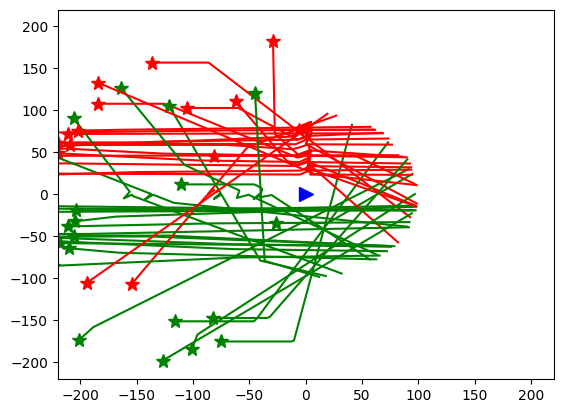

In [38]:
# file_name = "synthetic"
howmany=50
using_file_indices = np.arange(howmany)


fig = plt.figure()
ax = fig.add_subplot(111) # 2D

ax.set_xlim(-220, 220)
ax.set_ylim(-220, 220)

ax.plot(0, 0, '>', ms = 10, color='b') # ego vehicle

for using_file_idx in using_file_indices:

    # using_file_idx = 22 # 22
    unpickled_df = pd.read_pickle("./{}/synthetic_{}.pkl".format(path_save, str(using_file_idx)))
    # print(unpickled_df)

    if unpickled_df["label"][0] == "L":
        ax.plot(unpickled_df['x'], 
                unpickled_df['y'], color='r')
        ax.plot(unpickled_df['x'].iloc[-1], unpickled_df['y'].iloc[-1], '*', ms = 10, color='r')
    elif unpickled_df["label"][0] == "R": 
        ax.plot(unpickled_df['x'], 
                unpickled_df['y'], color='g')
        ax.plot(unpickled_df['x'].iloc[-1], unpickled_df['y'].iloc[-1], '*', ms = 10, color='g')

# if using_file_idx > 30:
#     break

In [39]:
unpickled_df.columns

Index(['x', 'y', 'v_x', 'v_y', 'global_x', 'global_y', 'rel_dist',
       'rel_bearing', 'rel_bearing_diff', 'comp_bearing', 'comp_bearing_diff',
       'Heading', 'situation', 'sin_rel_bearing', 'cos_rel_bearing',
       'sin_comp_bearing', 'cos_comp_bearing', 'valid', 'obj_index', 'label'],
      dtype='object')

<Axes: >

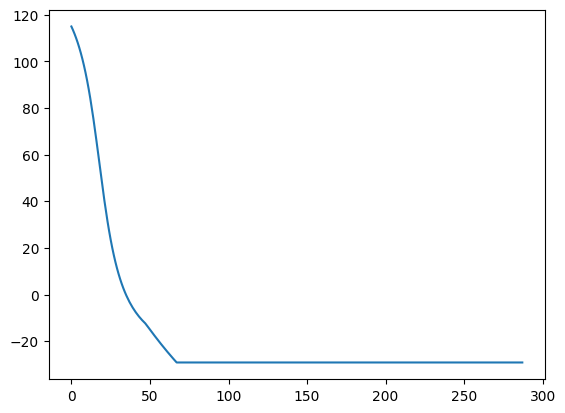

In [40]:
np.degrees(unpickled_df.comp_bearing).plot()

<Axes: >

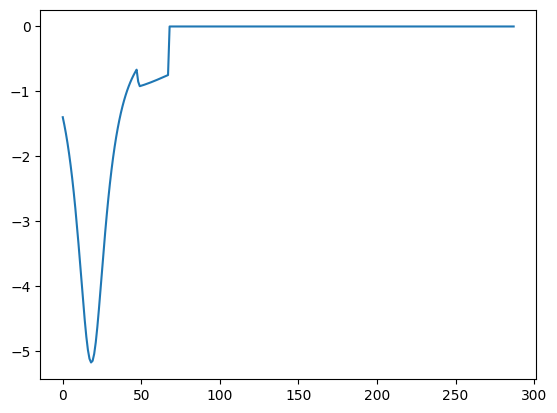

In [41]:
np.degrees(unpickled_df.comp_bearing_diff).plot()

In [42]:
unpickled_df.rel_dist.min()

52.74899537744806

## matplotlib plot for double checking

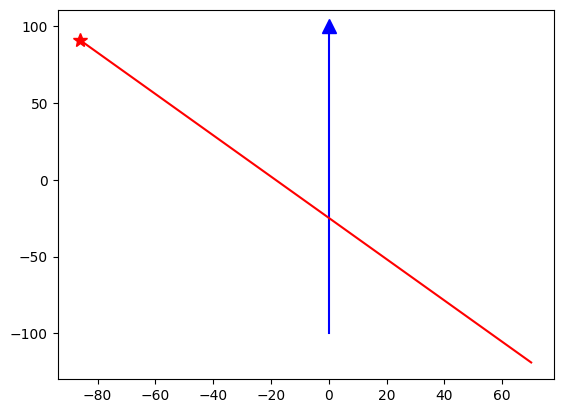

In [43]:
fig = plt.figure()
ax = fig.add_subplot(111) # 2D

ax.plot(0, 100, '^', ms = 10, color='b') # ego vehicle
ax.plot([MY_START_PSN[0], MY_END_PSN[0]], 
        [MY_START_PSN[1], MY_END_PSN[1]], color='b')
# ax.plot(i_robot_info['end_x'], i_robot_info['end_y'], '*', ms = 10, color='r')

ax.plot([70, -86], 
        [-119, 91], color='r')
ax.plot(-86, 91, '*', ms = 10, color='r')


# for robot_name, i_robot_info in entire_situation.items():
#         ax.plot([i_robot_info['start_x'], i_robot_info['end_x']], 
#                 [i_robot_info['start_y'], i_robot_info['end_y']], color='r')
#         ax.plot(i_robot_info['end_x'], i_robot_info['end_y'], '*', ms = 10, color='r')

#         ax.set_xlim(-220, 220)
#         ax.set_ylim(-220, 220)

plt.draw()
# plt.pause(0.1) # to make pop up

In [44]:
# # 5) rotation view
# start_arr = np.array([start_x, start_y])
# end_arr = np.array([end_x, end_y])
# rotated_pos = np.matmul(rot_mat, np.vstack([start_arr, end_arr]).T)
# rot_start_x, rot_start_y = rotated_pos[:, 0]
# rot_end_x, rot_end_y = rotated_pos[:, 1]

# robot_name = "robot_{}".format(robot_idx)
# entire_situation[robot_name] = {'situation': i_situation, 
#         'start_x': other_start_x,
#         'start_y': other_start_y,
#         'end_x': other_end_x,
#         'end_y': other_end_y,
#         'hdg': other_hdg,
#         'spd': other_spd}